# Steam Games Rating Prediction
In this exploration notebook, we will demonstrate the entire pipeline of our project.

First, we import external libraries along with the dataset that will be used throughout the project. 

We then proceed with the preprocessing phase, normalizing the given average ratings in terms of the number of total ratings (amongst other factors).

Then we clean the data to adhere to the preferred format of our machine learning models (namely numerical values for classification).

Finally, we attempt to implement the decision tree and support vector machine models, comparing their performance on our given testing dataset.

## Importing libraries

In [30]:
# Default libraries
from collections import Counter
# External Libraries
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

## Importing the dataset

In [31]:
data = pd.read_csv("datasets/steam_games_2024.csv")
data.head()

,appid,name,price,release_date,required_age,publishers,developers,categories,genres,ratings,totalRatings,average_playtime,median_playtime,num_owners
0,10,Counter-Strike,7.19,2000-11-01,0,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,97.39,127873,17612,317,10000000-20000000
1,20,Team Fortress Classic,3.99,1999-04-01,0,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,83.98,3951,277,62,5000000-10000000
2,30,Day of Defeat,3.99,2003-05-01,0,Valve,Valve,Multi-player;Valve Anti-Cheat enabled,Action,89.56,3814,187,34,5000000-10000000
3,40,Deathmatch Classic,3.99,2001-06-01,0,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,82.66,1540,258,184,5000000-10000000
4,50,Half-Life: Opposing Force,3.99,1999-11-01,0,Valve,Gearbox Software,Single-player;Multi-player;Valve Anti-Cheat en...,Action,94.80,5538,624,415,5000000-10000000


## Data Exploration

In this phase of the project, we got an overview of what our data looks like. This helps us target features that we hope can help us in our data models.

We begin by analyzing easily quantifiable metrics such as total ratings and average playtime. Intuition tells us that these will be amongst the more important features to emphasize and categorize.

Then we begin exploring other less quantifiable metrics such as publisher/developer reputation and genres/game categories.

### Distribution of Ratings

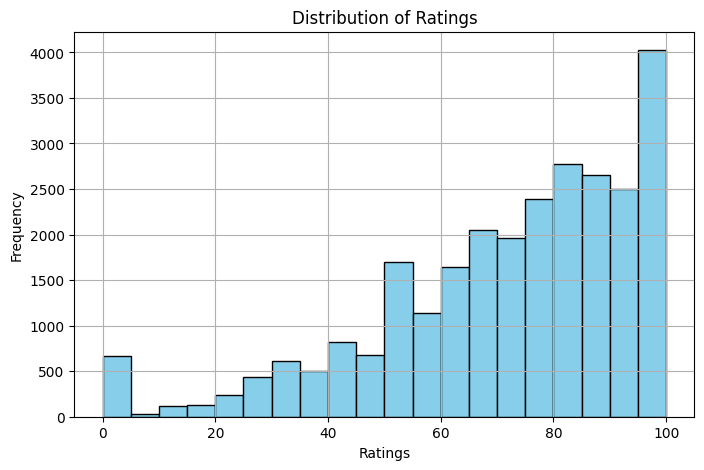

In [39]:
plt.figure(figsize=(8, 5))
plt.hist(data['ratings'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Average Playtime versus Ratings

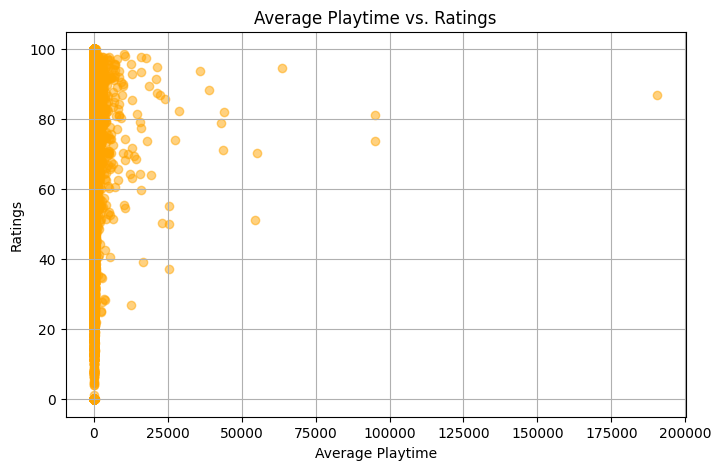

In [54]:
plt.figure(figsize=(8, 5))
plt.scatter(data['average_playtime'], data['ratings'], alpha=0.5, color='orange')
plt.title('Average Playtime vs. Ratings')
plt.xlabel('Average Playtime')
plt.ylabel('Ratings')
plt.grid(True)
plt.show()

### Number of Games released over time

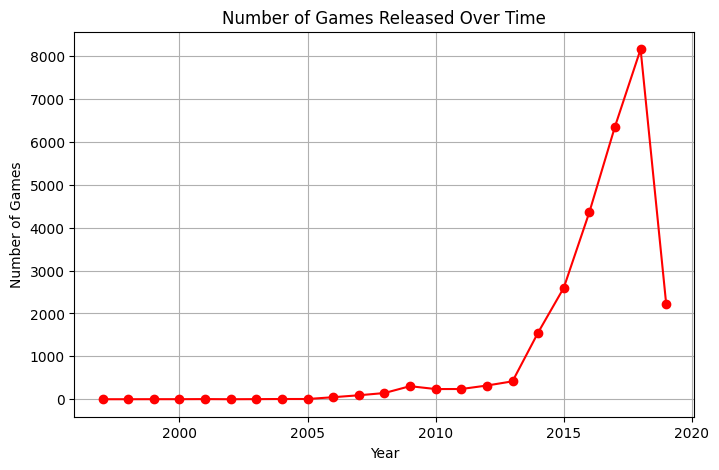

In [37]:
plt.figure(figsize=(8, 5))
data['release_date'] = pd.to_datetime(data['release_date'])
data['release_year'] = data['release_date'].dt.year
games_per_year = data.groupby('release_year').size()
games_per_year.plot(marker='o', color='red')
plt.title('Number of Games Released Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.grid(True)
plt.show()

### Top Genres Distribution

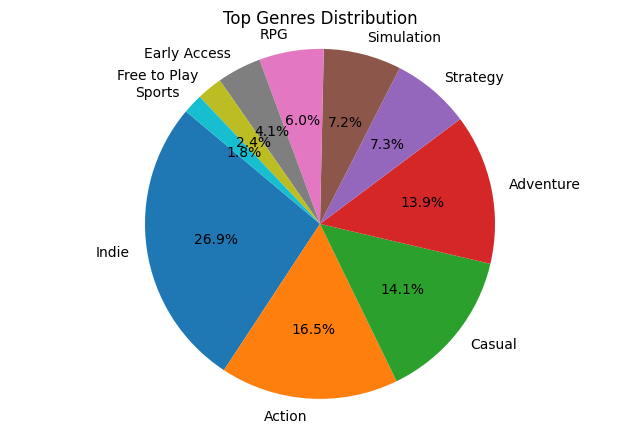

In [78]:
# Count occurrences of each genre
genre_counts = data['genres'].str.split(';').explode().value_counts()
# Select the top 10 genres
top_genres = genre_counts.head(10)

# Create a pie chart for top genres
plt.figure(figsize=(8, 5))
plt.pie(top_genres, labels=top_genres.index, autopct='%1.1f%%', startangle=140)
plt.title('Top Genres Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

### Top publishers and developers

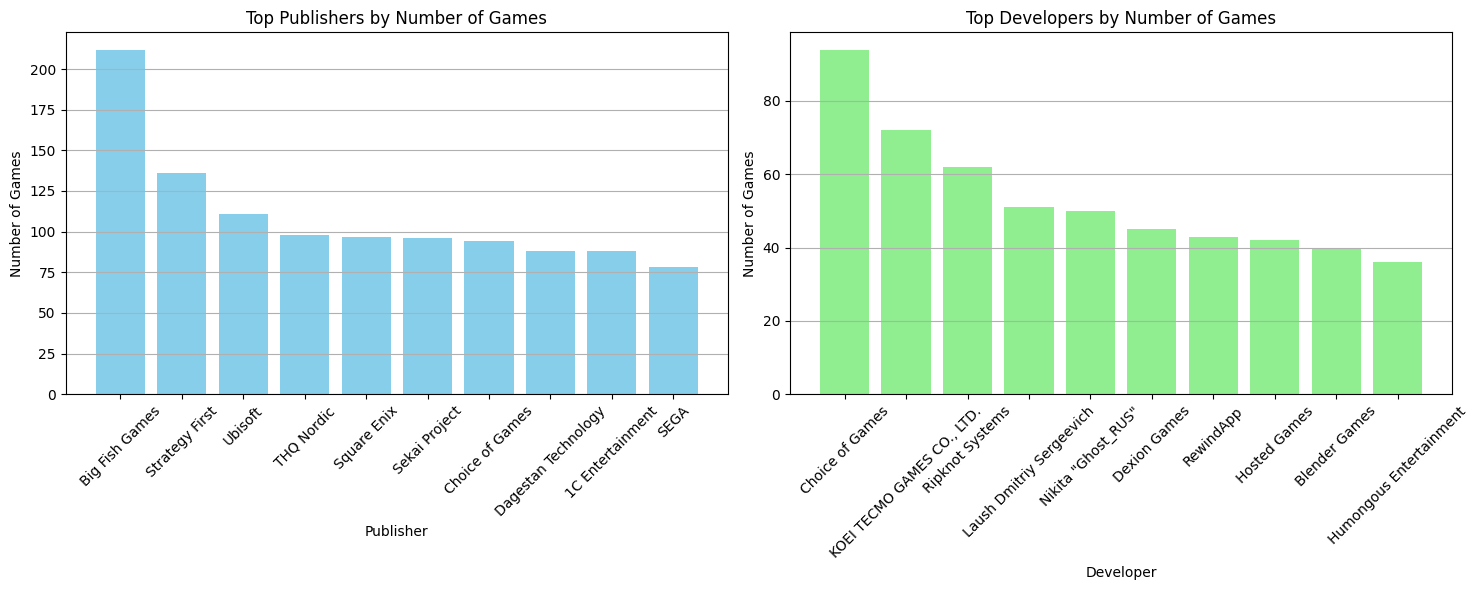

In [49]:
# Create a figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Top Publishers
top_publishers = data['publishers'].value_counts().head(10)
axs[0].bar(top_publishers.index, top_publishers.values, color='skyblue')
axs[0].set_title('Top Publishers by Number of Games')
axs[0].set_xlabel('Publisher')
axs[0].set_ylabel('Number of Games')
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(axis='y')

# Top Developers
top_developers = data['developers'].value_counts().head(10)
axs[1].bar(top_developers.index, top_developers.values, color='lightgreen')
axs[1].set_title('Top Developers by Number of Games')
axs[1].set_xlabel('Developer')
axs[1].set_ylabel('Number of Games')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y')

# Adjust layout
plt.tight_layout()
# Show the plots
plt.show()

### High Average Rating with Low number of ratings

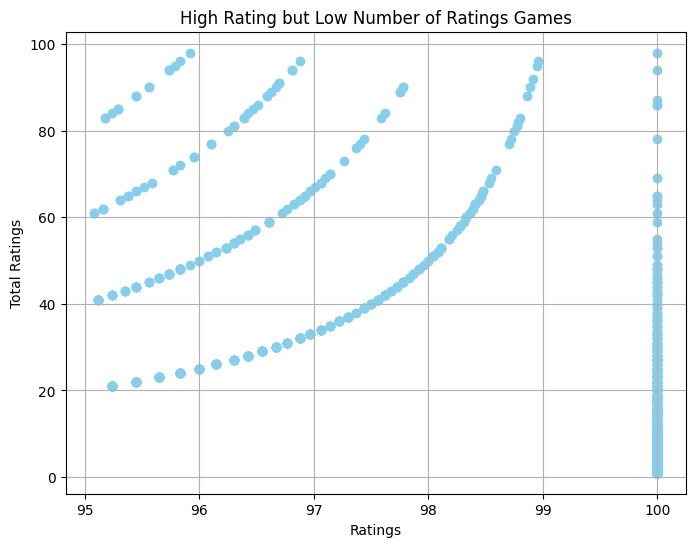

In [66]:
# Define thresholds for high ratings and low numbers of ratings
high_rating_threshold = 95  
low_ratings_threshold = 100 
filtered_df = data[(data['ratings'] > high_rating_threshold) & (data['totalRatings'] < low_ratings_threshold)]

# Create a scatter plot for high average rating but low number of ratings games
plt.figure(figsize=(8, 6))
plt.scatter(filtered_df['ratings'], filtered_df['totalRatings'], color='skyblue')
plt.title('High Rating but Low Number of Ratings Games')
plt.xlabel('Ratings')
plt.ylabel('Total Ratings')
plt.grid(True)
plt.show()

## Data preprocessing
- 
- 

### Added columns
- mean rating
- weighted rating

In [72]:
# Step 1: Determine the minimum number of ratings required to be listed, using the 50th percen|tile as a threshold
m = data['totalRatings'].quantile(0.50)
print(m)

# Step 2: Calculate C, the mean rating across all games
C = data['ratings'].mean()

# Apply the weighted rating formula
data['weighted_rating'] = (data['totalRatings'] / (data['totalRatings'] + m) * data['ratings']) + (m / (data['totalRatings'] + m) * C)

# Display the first few rows to verify the calculation
data[['name', 'ratings', 'totalRatings', 'weighted_rating']]
sorted  = data.sort_values(by=['totalRatings'], ascending=False)
sorted[sorted['totalRatings']> 36]

36.0


,appid,name,price,release_date,required_age,publishers,developers,categories,genres,ratings,totalRatings,average_playtime,median_playtime,num_owners,release_year,weighted_rating
25,730,Counter-Strike: Global Offensive,0.00,2012-08-21,0,Valve,Valve;Hidden Path Entertainment,Multi-player;Steam Achievements;Full controlle...,Action;Free to Play,86.80,3046717,22494,6502,50000000-100000000,2012,86.799819
22,570,Dota 2,0.00,2013-07-09,0,Valve,Valve,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,85.87,1005586,23944,801,100000000-200000000,2013,85.869484
12836,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,26.99,2017-12-21,0,PUBG Corporation,PUBG Corporation,Multi-player;Online Multi-Player;Stats,Action;Adventure;Massively Multiplayer,50.46,983260,22938,12434,50000000-100000000,2017,50.460768
19,440,Team Fortress 2,0.00,2007-10-10,0,Valve,Valve,Multi-player;Cross-Platform Multiplayer;Steam ...,Action;Free to Play,93.81,549915,8495,623,20000000-50000000,2007,93.808536
2478,271590,Grand Theft Auto V,24.99,2015-04-13,18,Rockstar Games,Rockstar North,Single-player;Multi-player;Steam Achievements;...,Action;Adventure,70.26,468369,9837,4834,10000000-20000000,2015,70.260091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18763,755670,Sleep Tight,11.39,2018-07-26,0,We Are Fuzzy,We Are Fuzzy,Single-player;Steam Achievements;Full controll...,Action;Indie;Strategy,86.49,37,0,0,0-20000,2018,79.071959
9942,500320,A Tale of Caos: Overture,5.99,2016-12-21,0,Eli Daddio,ExperaGameStudio,Single-player;Steam Achievements;Steam Trading...,Adventure;Indie,70.27,37,0,0,0-20000,2016,70.850863
7473,423440,Choice of Kung Fu,3.99,2015-12-11,0,Choice of Games,Choice of Games,Single-player;Steam Achievements;Captions avai...,Indie;RPG,94.59,37,0,0,0-20000,2015,83.177438
20540,805450,Derrek Quest V Regression,0.79,2018-02-28,0,Alexeibelih,Manuf,Single-player,Action;Adventure;Casual;Indie,48.65,37,0,0,0-20000,2018,59.892780


In [73]:
# Isolating the 'weighted_rating' column for K-means
X = sorted[['weighted_rating']]

# Using the elbow method to find the optimal number of clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(n_clusters=3)